# Transfer Learning with TensorFlow/Keras

## Introduction to Transfer Learning

Transfer learning is a powerful technique in machine learning where a pre-trained model, developed for a particular task, is reused as the starting point for a model on a different task. This approach is particularly useful when the second task has limited data.

In this notebook, we'll demonstrate transfer learning by using a pre-trained VGG16 model and applying it to a new image classification task using the CIFAR-10 dataset. We'll utilize TensorFlow and Keras libraries for this purpose.

## Importing Libraries

First, let's import the necessary libraries.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


## Loading and Preprocessing Data

We'll use the CIFAR-10 dataset for this demonstration. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. Let's load and preprocess the data.

### Steps:
1. Load the CIFAR-10 dataset.
2. Normalize the images to the range [0, 1].
3. Convert class vectors to binary class matrices (one-hot encoding).
4. Display some sample images.


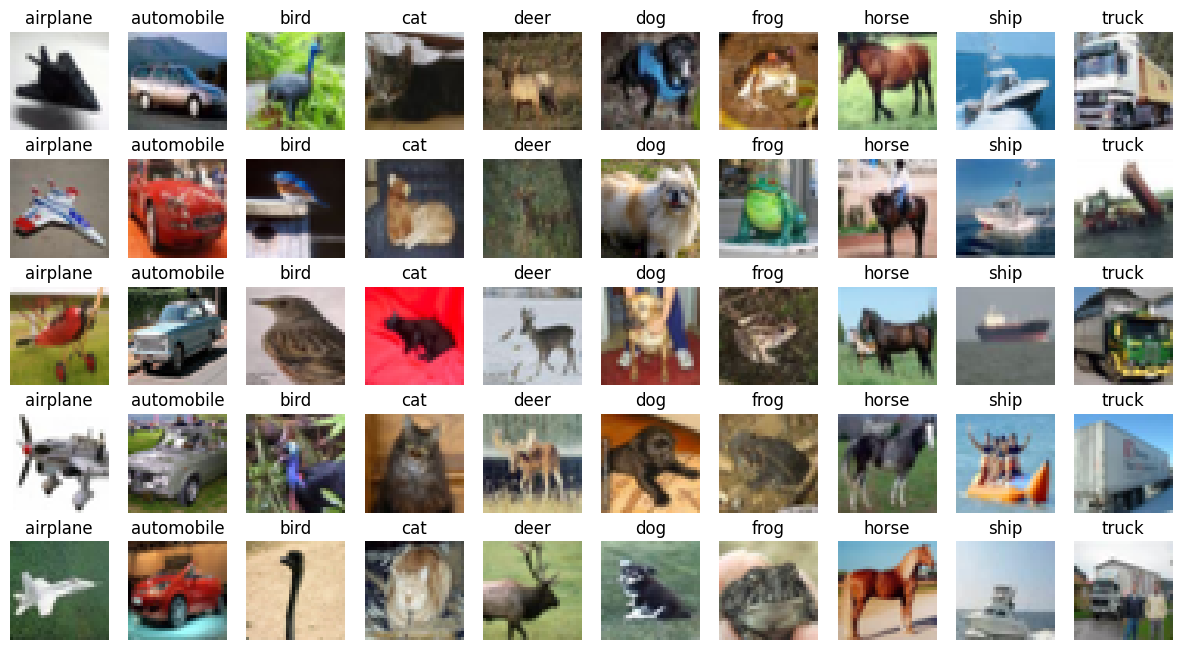

In [2]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Display some sample images
def plot_sample_images(x, y, class_names, samples_per_class=5):
    plt.figure(figsize=(15, 8))
    for i in range(samples_per_class):
        for j in range(len(class_names)):
            index = np.where(y == j)[0][i]
            plt.subplot(samples_per_class, len(class_names), i * len(class_names) + j + 1)
            plt.imshow(x[index])
            plt.title(class_names[j])
            plt.axis('off')
    plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plot_sample_images(x_train, np.argmax(y_train, axis=1), class_names)


## Building the Model

We will use the VGG16 model pre-trained on the ImageNet dataset. We'll remove the top fully connected layers and add our own dense layers for the CIFAR-10 classification task.

### Steps:
1. Load the VGG16 model without the top fully connected layers.
2. Freeze the base model layers to prevent them from being updated during training.
3. Add custom classification layers on top of the base model.
4. Compile the model with an appropriate optimizer, loss function, and evaluation metric.


In [3]:
# Load the VGG16 model without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])




58889256/58889256 [==============================] - 2s 0us/step


## Training the Model

We'll use data augmentation to improve the generalization of our model. Data augmentation is a technique to artificially increase the size of a training dataset by creating modified versions of images in the dataset.

### Steps:
1. Create an image data generator with data augmentation.
2. Fit the data generator to the training data.
3. Train the model using the data generator.


In [4]:
# Create an image data generator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Train the model
batch_size = 64
epochs = 10

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))


Epoch 1/10


781/781 [==============================] - 141s 179ms/step - loss: 1.5394 - accuracy: 0.4533 - val_loss: 1.3645 - val_accuracy: 0.5160
Epoch 2/10
781/781 [==============================] - 151s 194ms/step - loss: 1.3826 - accuracy: 0.5083 - val_loss: 1.2864 - val_accuracy: 0.5464
Epoch 3/10
781/781 [==============================] - 235s 301ms/step - loss: 1.3321 - accuracy: 0.5267 - val_loss: 1.2272 - val_accuracy: 0.5680
Epoch 4/10
781/781 [==============================] - 207s 266ms/step - loss: 1.3094 - accuracy: 0.5374 - val_loss: 1.1922 - val_accuracy: 0.5776
Epoch 5/10
781/781 [==============================] - 243s 310ms/step - loss: 1.2800 - accuracy: 0.5468 - val_loss: 1.2135 - val_accuracy: 0.5761
Epoch 6/10
781/781 [==============================] - 231s 295ms/step - loss: 1.2583 - accuracy: 0.5545 - val_loss: 1.2038 - val_accuracy: 0.5718
Epoch 7/10
781/781 [==============================] - 230s 294ms/step - loss: 1.2472 - accuracy: 0.5567 - val_loss: 1.1520

## Evaluating the Model

After training, we need to evaluate the model's performance on the test data. We'll also visualize the training history to understand how the model improved over time.

### Steps:
1. Plot the training history.
2. Evaluate the model on the test data.


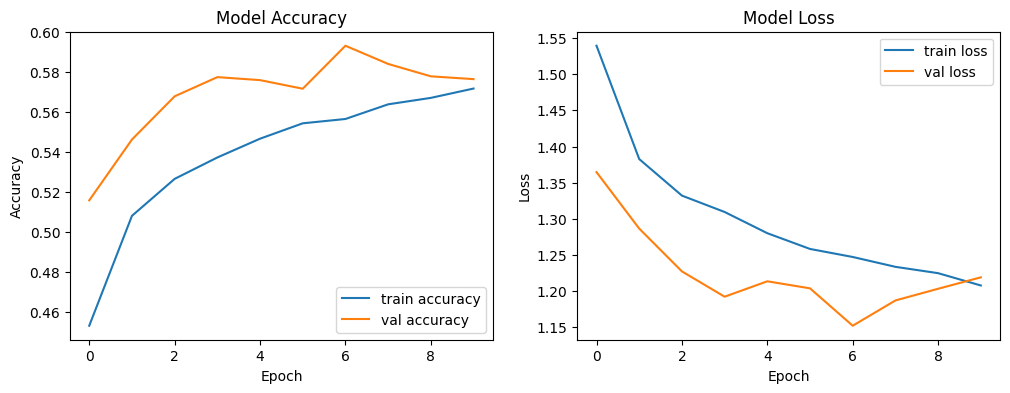

313/313 - 51s - loss: 1.2190 - accuracy: 0.5766 - 51s/epoch - 163ms/step
Test accuracy: 0.58


In [5]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy:.2f}')


## Conclusion

In this notebook, we've demonstrated the process of transfer learning using the VGG16 model pre-trained on ImageNet and applied it to the CIFAR-10 dataset. We built a new model on top of the pre-trained layers, trained it with data augmentation, and evaluated its performance.

Transfer learning allows us to leverage existing models to improve performance on new tasks with limited data, making it a powerful tool in the machine learning toolbox.
